In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [8]:


def get_initial(n, xmin, xmax, dx):
    u = np.zeros(n)
    x = np.zeros(n)
    
    for i in range(n):
        x[i] = xmin + i * dx
        # ----- Change me -------
        u[i] = np.exp(-x[i]**2) * np.sin( np.pi * x[i] / 3)
        # -----------------------
    return x, u

def driving(n, xmin, xmax, dx, t):
    v = np.zeros(n)
    for i in range(1, n-1):
        x = xmin + i * dx
    # ----- Change me -------
    # Caveats: keep the range as is.
        v[i] = 0
    # -----------------------
    return v
    

def second_der(u, dxm2):
    v = np.zeros(u.shape[0])
    for i in range(1,u.shape[0]-1):
        v[i] = (u[i+1] - 2*u[i] + u[i-1]) * dxm2
    return v

class RungeKutta:
    
    def __init__(self, n, h):
        self.n = n
        self.h = h
        self.xmin = -3
        self.xmax = +3
        self.dx = (self.xmax-self.xmin) / (n-1)
        self.dxm2 = 1 / (self.dx * self.dx)
        self.t = 0
        self.rad_coeff = 1
        
        self.x, self.u = get_initial(n, self.xmin, self.xmax, self.dx)
        self.u0 = np.copy(self.u)
        self.uD = np.copy(self.u)
        
        self.k1 = np.zeros(n)
        self.k2 = np.zeros(n)
        self.k3 = np.zeros(n)
        self.k4 = np.zeros(n)

        self.ks = np.zeros((n,7))
        self.tableaux = np.zeros((7,7))
        self.b = np.array([35/384,0,500/1113, 125/192, -2187/6784, 11/84, 0])
        
        self.tableaux[1,0] = 1/5

        self.tableaux[2,0] = 3/40
        self.tableaux[2,1] = 9/40

        self.tableaux[3,0] = 44/45
        self.tableaux[3,1] = -56/15
        self.tableaux[3,2] = 32/9

        self.tableaux[4,0] = 19372/6561
        self.tableaux[4,1] = -25360/2187
        self.tableaux[4,2] = 64448/6561
        self.tableaux[4,3] = -212/729

        self.tableaux[5,0] = 9017/3168
        self.tableaux[5,1] = -355/33
        self.tableaux[5,2] = 46732/5247
        self.tableaux[5,3] = 49/176
        self.tableaux[5,4] = -5103/18656

        self.tableaux[6,0] = 35/384
        self.tableaux[6,1] = 0
        self.tableaux[6,2] = 500/1113
        self.tableaux[6,3] = 125/192
        self.tableaux[6,4] = -2187/6784
        self.tableaux[6,5] = 11/84

    def hamiltonian(self, y):
        return second_der(y,self.dxm2) + self.rad_coeff * (driving(self.n, self.xmin, self.xmax, self.dx, self.t) - y**4)
        
    def step4th(self):
        self.k1 = self.h * 0.5 * self.hamiltonian(self.u)
        self.k2 = self.h * 0.5 * self.hamiltonian(self.u + self.k2)
        self.k3 = self.h * 1.0 * self.hamiltonian(self.u + self.k3)
        self.k4 = self.h * 0.5 * self.hamiltonian(self.u + self.k4)
        self.u += (self.k1 + 2*self.k2 + self.k3 + self.k4) / 3
        self.t += self.h

    def stepDOPRI(self):
        for i in range(7):
            tmp = np.zeros(self.n)
            for j in range(i-1):
                tmp += self.ks[:,j] * self.tableaux[i,j]
            self.ks[:,i] = second_der(self.uD + tmp * self.h,self.dxm2)
        
        for i in range(7):
            self.uD += self.h * self.b[i] * self.ks[:,i]

        

In [9]:
n = 100
xmin = -3
xmax = +3
dx = (xmax-xmin) / (n-1)
rk_h = 1e-4
sol = RungeKutta(n, rk_h)

In [10]:
save_count = 100
full_data = np.zeros((save_count+1, n))
times = np.zeros(save_count+1)
n_step = 10_000
for t in range(n_step):
    if t % save_count == 0:
        j = t // save_count
        full_data[j] = np.copy(sol.u)
        times[j] = sol.t
    sol.step4th()

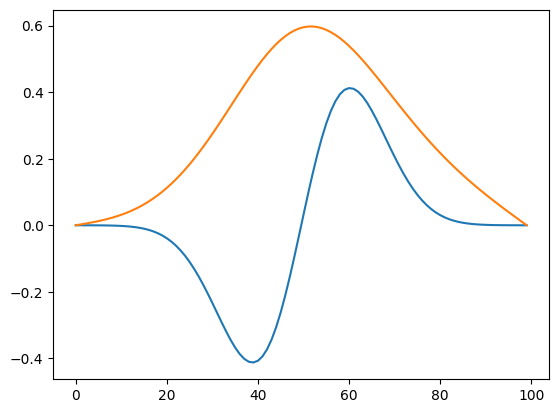

In [11]:
plt.plot(sol.u0)
plt.plot(sol.u)

2000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


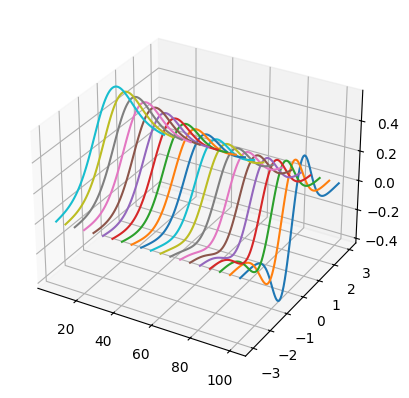

In [12]:
ax = plt.figure().add_subplot(projection='3d')

tmp = np.zeros((sol.x.shape[0] * 20, 3))
print(tmp.shape[0])

for i in range(0,save_count,5):
    norm = np.amax(np.abs(full_data[i,:]))

    ax.plot(sol.x, full_data[i,:], save_count+1-i, zdir='x')
    j = i // 5
    low = j * sol.x.shape[0]
    high = (j+1) * sol.x.shape[0]
    print(j)
    tmp[low:high, 0] = times[i]
    tmp[low:high, 1] = np.copy(sol.x)
    tmp[low:high, 2] = np.copy(full_data[i, :])

np.savetxt("data_heat_eq.dat", tmp, fmt="%.6e")